This notebook is part of the $\omega radlib$ documentation: http://wradlib.org/wradlib-docs.

Copyright (c) 2016, $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Simple fuzzy echo classification from dual-pol moments 

In [8]:
import wradlib
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Setting the file paths

In [4]:
rhofile = wradlib.util.get_wradlib_data_file('netcdf/TAG-20120801-140046-02-R.nc')
phifile = wradlib.util.get_wradlib_data_file('netcdf/TAG-20120801-140046-02-P.nc')
reffile = wradlib.util.get_wradlib_data_file('netcdf/TAG-20120801-140046-02-Z.nc')
dopfile = wradlib.util.get_wradlib_data_file('netcdf/TAG-20120801-140046-02-V.nc')
zdrfile = wradlib.util.get_wradlib_data_file('netcdf/TAG-20120801-140046-02-D.nc')
mapfile = wradlib.util.get_wradlib_data_file('hdf5/TAG_cmap_sweeps_0204050607.hdf5')

## Read the data (radar moments and static clutter map)

In [5]:
# We need to organize our data as a dictionary
dat = {}
dat["rho"], attrs_rho = wradlib.io.read_EDGE_netcdf(rhofile)
dat["phi"], attrs_phi = wradlib.io.read_EDGE_netcdf(phifile)
dat["ref"], attrs_ref = wradlib.io.read_EDGE_netcdf(reffile)
dat["dop"], attrs_dop = wradlib.io.read_EDGE_netcdf(dopfile)
dat["zdr"], attrs_zdr = wradlib.io.read_EDGE_netcdf(zdrfile)
dat["map"]            = wradlib.io.from_hdf5(mapfile)[0][0]

## Identify non-meteorological echoes using fuzzy echo classification

See [Crisologo et al. (2015)](http://link.springer.com/article/10.1007/s13143-014-0049-y) and [Vulpiani et al. (2012)](http://journals.ametsoc.org/doi/abs/10.1175/JAMC-D-10-05024.1) for details.

In [23]:
weights = {"zdr": 0.4, "rho": 0.4, "rho2": 0.4, "phi": 0.1, "dop": 0.1, "map": 0.5}
cmap, nanmask = wradlib.clutter.classify_echo_fuzzy(dat, weights=weights, thresh=0.5)

## View classfication results

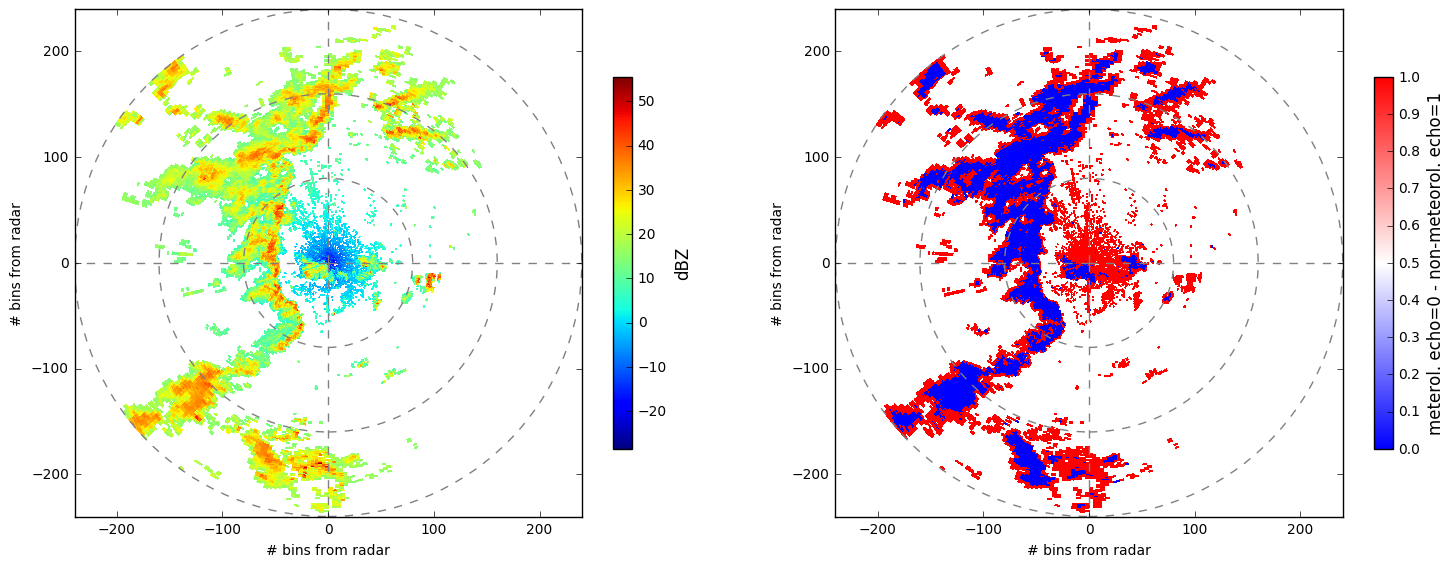

In [24]:
fig = plt.figure(figsize=(18,16))

#   Horizontal reflectivity
ax = plt.subplot(121, aspect="equal")
ax, pm = wradlib.vis.plot_ppi(np.ma.masked_invalid(dat["ref"]))
ax = wradlib.vis.plot_ppi_crosshair(site=(0,0), ranges=[80,160,240])
plt.xlim(-240,240)
plt.ylim(-240,240)
plt.xlabel("# bins from radar")
plt.ylabel("# bins from radar")
cbar = plt.colorbar(pm, shrink=0.3)
cbar.set_label("dBZ", fontsize = "large")

#   Echo classification
ax = plt.subplot(122, aspect="equal")
ax, pm = wradlib.vis.plot_ppi(np.ma.masked_array( cmap, np.isnan(dat["ref"])), cmap="bwr")
ax = wradlib.vis.plot_ppi_crosshair(site=(0,0), ranges=[80,160,240])
plt.xlim(-240,240)
plt.ylim(-240,240)
plt.xlabel("# bins from radar")
plt.ylabel("# bins from radar")
cbar = plt.colorbar(pm, shrink=0.3)
cbar.set_label("meterol. echo=0 - non-meteorol. echo=1", fontsize = "large")